# Transfer Learning in RUL Estimation

One of my referees was "A Data-driven approach for Remaining Useful Life Prediction of Aircraft Engines". In this paper, my experiment is developed using various techniques. The results table of this paper is my reference point to see if my model is good or not.

| Methods              | RMSE    | Score  |
|----------------------|---------|--------|
| ESN                  | 63.4565 | -      |
| SVM                  | 29.823  | -      |
| SVR                  | 20.9640 | 1381.5 |
| CNN                  | 18.448  | 1282.7 |
| Stacking rnsemble    | 16.67   | -      |
| Deep LSTM            | 16.14   | 338    |
| Time window based NN | 15.1593 | -      |
| Time window + ELM    | 13.78   | 267.31 |


# Settings

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sun Jul 18 14:04:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Import libraries in python
import argparse
import time
import json
import logging
import sys
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from itertools import repeat
from scipy.stats import randint, expon, uniform

import tensorflow as tf
import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
import cv2
import io
from PIL import Image
from numba import jit, cuda
from Utils.cnn import gen_net, network_fit



# Ignore tf err log
pd.options.mode.chained_assignment = None  # default='warn'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

# random seed predictable
seed = 0
random.seed(seed)
np.random.seed(seed)


current_dir = os.path.dirname(os.path.abspath(__file__))

## Dataset path
train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

train_FD002_path = current_dir +'/cmapss/train_FD002.csv'
test_FD002_path = current_dir +'/cmapss/test_FD002.csv'
RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

train_FD003_path = current_dir +'/cmapss/train_FD003.csv'
test_FD003_path = current_dir +'/cmapss/test_FD003.csv'
RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

train_FD004_path = current_dir +'/cmapss/train_FD004.csv'
test_FD004_path = current_dir +'/cmapss/test_FD004.csv'
RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]

## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']

## Read csv file to pandas dataframe
FD_path = ["none", FD001_path, FD002_path, FD003_path, FD004_path]
dp_str = ["none", "FD001", "FD002", "FD003", "FD004"]

## temporary model path for NN
model_path = current_dir +'/temp_net.h5'


#start = time.time()

# Architecture preferences
dp = FD_path[1]
subdataset = dp_str[1]
sequence_length = 32
thres_type = None
thres_value = 50
device = 'cpu'
method = 'rps'
epochs = 1500
batch = 500
verbose = 1
flatten = False
visualize = False


Mounted at /content/drive


In [ ]:
settings = [
            {
              "title": "From scratch",
              "weights": False,
              "freeze": False,
              "not_train": 0,
              "top": False
            },
            {
              "title": "Freezing top 2 layers",
              "weights": True,
              "freeze": True,
              "not_train": 3,
              "top": True
            },
            {
              "title": "Freezing last 15-18 layers",
              "weights": True,
              "freeze": True,
              "not_train": 4,
              "top": False
            },
            {
              "title": "Freezing last 13-18 layers",
              "weights": True,
              "freeze": True,
              "not_train": 6,
              "top": False
            },
            {
              "title": "Freezing last 8-18 layers",
              "weights": True,
              "freeze": True,
              "not_train": 11,
              "top": False
            },
            {
              "title": "TL whole net",
              "weights": True,
              "freeze": False,
              "not_train": 0,
              "top": False
            }
]

# Main


In [ ]:
# Inizializzo variebili globali
test_samples = np.load(current_dir +'/preprocess/test_samples.npy')
label_array_test = np.load(current_dir +'/preprocess/label_array_test.npy')
train_num = 100

In [ ]:
# Inizializzo variabili locali
i = 1
results = []

setting = {
              "title": "no weights no freezing",
              "weights": False,
              "freeze": False,
              "not_train": 0,
              "top": False
            }

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)

mlps_net = network_fit(train_samples, 
                      label_array_train, 
                      test_samples, 
                      label_array_test,
                      model_path = model_path, 
                      model_name = "vgg19",
                      weights = setting['weights'],
                      freeze = setting['freeze'],
                      not_train = setting['not_train'],
                      top = setting['top'],
                      verbose=verbose)



train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 6

train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 6

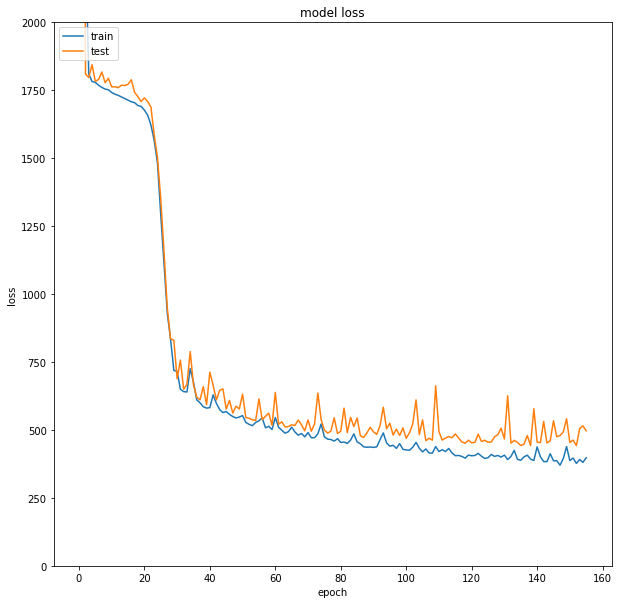

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   113.250275     98.0  15.250275     0.155615   15.561504  17.506393
1    53.840248     69.0  15.159752     0.219707   21.970655  17.506393
2    92.098259     82.0  10.098259     0.123149   12.314950  17.506393
3   104.914917     91.0  13.914917     0.152911   15.291117  17.506393
4   102.767097     93.0   9.767097     0.105023   10.502255  17.506393
5    97.497154     91.0   6.497154     0.071397    7.139729  17.506393
6    89.980133     95.0   5.019867     0.052841    5.284070  17.506393
7   102.838135    111.0   8.161865     0.073530    7.353032  17.506393
8    98.861786     96.0   2.861786     0.029810    2.981027  17.506393
9    79.675453     97.0  17.324547     0.178604   17.860357  17.506393
10   87.359665    124.0  36.640335     0.295487   29.548656  17.506393
11   81.348312     95.0  13.651688     0.143702   14.370197  17.506393
12  115.618111    107.0   8.618111     0.080543    8.054309  17.506393
13   9

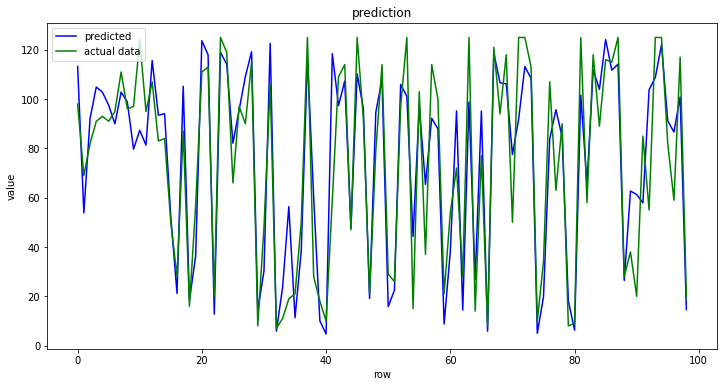

FD001 test RMSE:  17.506392700964714
FD001 test Score:  926.5285428927002
                  Methods       RMSE       Score  Epochs
0  no weights no freezing  17.506393  926.528543     153


In [ ]:
# Inizializzo variabili locali
i = 2
results = []

setting = {
              "title": "no weights no freezing",
              "weights": False,
              "freeze": False,
              "not_train": 0,
              "top": False
            }

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)

mlps_net = network_fit(train_samples, 
                      label_array_train, 
                      test_samples, 
                      label_array_test,
                      model_path = model_path, 
                      model_name = "vgg19",
                      weights = setting['weights'],
                      freeze = setting['freeze'],
                      not_train = setting['not_train'],
                      top = setting['top'],
                      verbose=verbose)


# Train
trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
# Test
rms, score = mlps_net.test_net(trained_net)
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

# Carico i risultati o li creo da zero
try:
  df_results = pd.read_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index_col=False)
  results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
  df_results = df_results.append(results, ignore_index=True)
except:
  df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

df_results.to_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index=False)
print(df_results)

train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 6

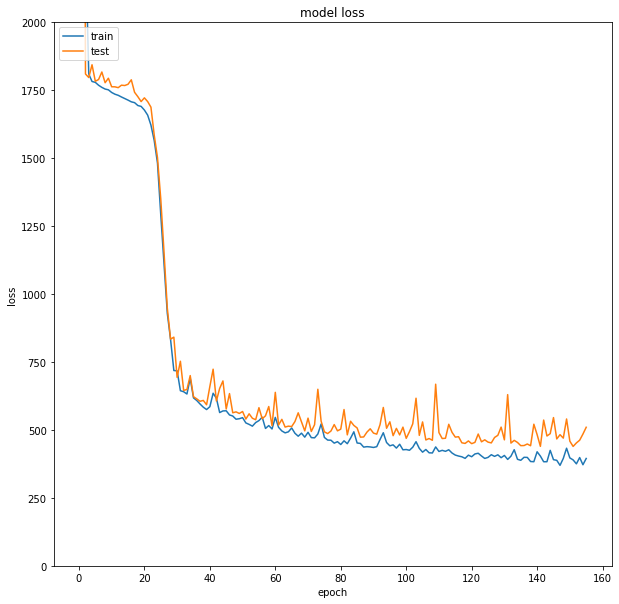

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   114.731140     98.0  16.731140     0.170726   17.072592  18.383159
1    60.021286     69.0   8.978714     0.130126   13.012629  18.383159
2    97.625305     82.0  15.625305     0.190553   19.055250  18.383159
3   108.523598     91.0  17.523598     0.192567   19.256701  18.383159
4   105.844734     93.0  12.844734     0.138115   13.811543  18.383159
5   101.111160     91.0  10.111160     0.111112   11.111165  18.383159
6    95.783264     95.0   0.783264     0.008245    0.824489  18.383159
7   107.003197    111.0   3.996803     0.036007    3.600724  18.383159
8   102.124619     96.0   6.124619     0.063798    6.379811  18.383159
9    84.814163     97.0  12.185837     0.125627   12.562719  18.383159
10   92.174522    124.0  31.825478     0.256657   25.665707  18.383159
11   86.534943     95.0   8.465057     0.089106    8.910586  18.383159
12  120.233414    107.0  13.233414     0.123677   12.367676  18.383159
13   9

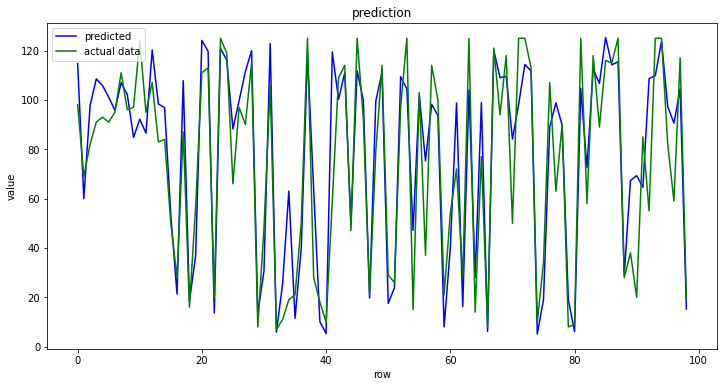

FD001 test RMSE:  18.383159460707848
FD001 test Score:  1252.0489240397255
                  Methods       RMSE        Score  Epochs
0  no weights no freezing  18.383159  1252.048924     152


In [ ]:
# Inizializzo variabili locali
i = 3
results = []

setting = {
              "title": "no weights no freezing",
              "weights": False,
              "freeze": False,
              "not_train": 0,
              "top": False
            }

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)

mlps_net = network_fit(train_samples, 
                      label_array_train, 
                      test_samples, 
                      label_array_test,
                      model_path = model_path, 
                      model_name = "vgg19",
                      weights = setting['weights'],
                      freeze = setting['freeze'],
                      not_train = setting['not_train'],
                      top = setting['top'],
                      verbose=verbose)


# Train
trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
# Test
rms, score = mlps_net.test_net(trained_net)
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

# Carico i risultati o li creo da zero
try:
  df_results = pd.read_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index_col=False)
  results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
  df_results = df_results.append(results, ignore_index=True)
except:
  df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

df_results.to_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index=False)
print(df_results)

train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 6

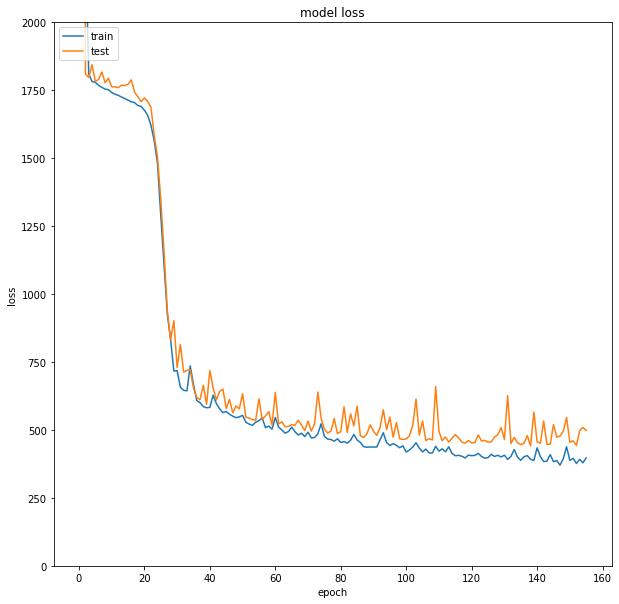

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   115.793808     98.0  17.793808     0.181569   18.156948  17.983519
1    54.881504     69.0  14.118496     0.204616   20.461588  17.983519
2    92.946518     82.0  10.946518     0.133494   13.349412  17.983519
3   106.084869     91.0  15.084869     0.165768   16.576778  17.983519
4   104.253693     93.0  11.253693     0.121007   12.100745  17.983519
5    99.693817     91.0   8.693817     0.095536    9.553645  17.983519
6    92.593544     95.0   2.406456     0.025331    2.533112  17.983519
7   105.379478    111.0   5.620522     0.050635    5.063533  17.983519
8   101.774124     96.0   5.774124     0.060147    6.014712  17.983519
9    83.751137     97.0  13.248863     0.136586   13.658622  17.983519
10   90.479851    124.0  33.520149     0.270324   27.032379  17.983519
11   83.052422     95.0  11.947578     0.125764   12.576398  17.983519
12  116.984268    107.0   9.984268     0.093311    9.331092  17.983519
13   9

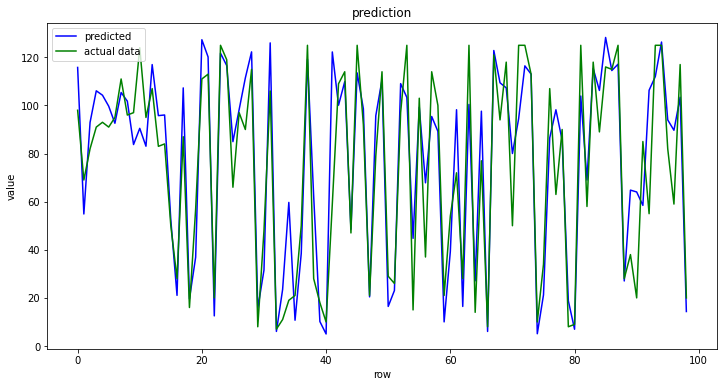

FD001 test RMSE:  17.983518896597985
FD001 test Score:  1213.5913857069156
                  Methods       RMSE        Score  Epochs
0  no weights no freezing  17.983519  1213.591386     139


In [ ]:
# Inizializzo variabili locali
i = 4
results = []

setting = {
              "title": "no weights no freezing",
              "weights": False,
              "freeze": False,
              "not_train": 0,
              "top": False
            }

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)

mlps_net = network_fit(train_samples, 
                      label_array_train, 
                      test_samples, 
                      label_array_test,
                      model_path = model_path, 
                      model_name = "vgg19",
                      weights = setting['weights'],
                      freeze = setting['freeze'],
                      not_train = setting['not_train'],
                      top = setting['top'],
                      verbose=verbose)


# Train
trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
# Test
rms, score = mlps_net.test_net(trained_net)
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

# Carico i risultati o li creo da zero
try:
  df_results = pd.read_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index_col=False)
  results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
  df_results = df_results.append(results, ignore_index=True)
except:
  df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

df_results.to_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index=False)
print(df_results)

train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 6

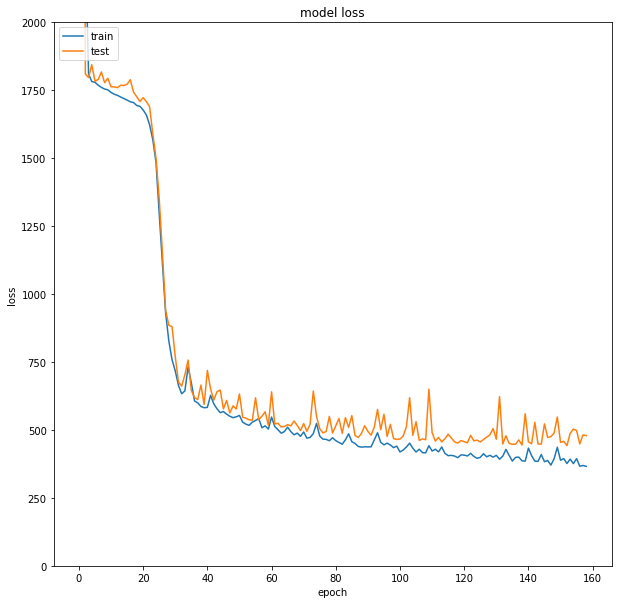

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   113.164444     98.0  15.164444     0.154739   15.473923  17.543381
1    53.739651     69.0  15.260349     0.221164   22.116447  17.543381
2    92.219864     82.0  10.219864     0.124632   12.463248  17.543381
3   104.534302     91.0  13.534302     0.148729   14.872859  17.543381
4   102.347466     93.0   9.347466     0.100510   10.051038  17.543381
5    96.697891     91.0   5.697891     0.062614    6.261419  17.543381
6    90.025230     95.0   4.974770     0.052366    5.236599  17.543381
7   103.080879    111.0   7.919121     0.071343    7.134343  17.543381
8    98.575356     96.0   2.575356     0.026827    2.682662  17.543381
9    80.297005     97.0  16.702995     0.172196   17.219582  17.543381
10   87.567131    124.0  36.432869     0.293813   29.381348  17.543381
11   81.291832     95.0  13.708168     0.144297   14.429651  17.543381
12  116.059151    107.0   9.059151     0.084665    8.466496  17.543381
13   9

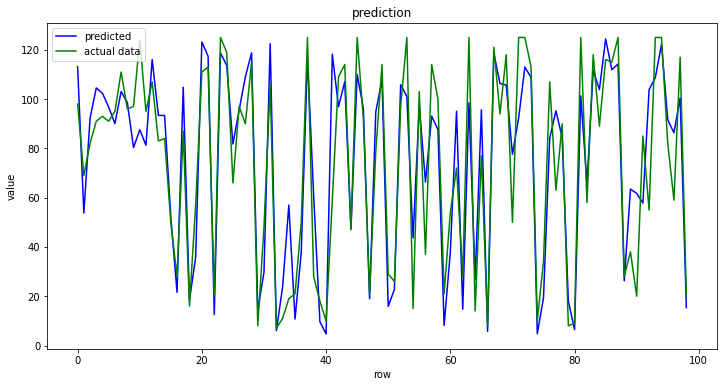

FD001 test RMSE:  17.543380593167292
FD001 test Score:  923.2164724738849
                  Methods       RMSE       Score  Epochs
0  no weights no freezing  17.543381  923.216472     153


In [ ]:
# Inizializzo variabili locali
i = 5
results = []

setting = {
              "title": "no weights no freezing",
              "weights": False,
              "freeze": False,
              "not_train": 0,
              "top": False
            }

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)

mlps_net = network_fit(train_samples, 
                      label_array_train, 
                      test_samples, 
                      label_array_test,
                      model_path = model_path, 
                      model_name = "vgg19",
                      weights = setting['weights'],
                      freeze = setting['freeze'],
                      not_train = setting['not_train'],
                      top = setting['top'],
                      verbose=verbose)


# Train
trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
# Test
rms, score = mlps_net.test_net(trained_net)
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

# Carico i risultati o li creo da zero
try:
  df_results = pd.read_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index_col=False)
  results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
  df_results = df_results.append(results, ignore_index=True)
except:
  df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

df_results.to_csv(current_dir + '/results/VGG19/Train_results'+str(i)+'.csv', index=False)
print(df_results)

# FINE PROVA

In [ ]:
# Inizializzo variabili locali
i = 2
results = []

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)
for setting in settings:
  mlps_net = network_fit(train_samples, 
                        label_array_train, 
                        test_samples, 
                        label_array_test,
                        model_path = model_path, 
                        model_name = "vgg",
                        weights = setting['weights'],
                        freeze = setting['freeze'],
                        not_train = setting['not_train'],
                        top = setting['top'],
                        verbose=verbose)

  # Train
  trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
  # Test
  rms, score = mlps_net.test_net(trained_net)
  print(subdataset + " test RMSE: ", rms)
  print(subdataset + " test Score: ", score)

  # Carico i risultati o li creo da zero
  try:
    df_results = pd.read_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index_col=False)
    results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
    df_results = df_results.append(results, ignore_index=True)
  except:
    df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

  df_results.to_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index=False)
  print(df_results)

In [ ]:
# Inizializzo variabili locali
i = 3
results = []

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')
print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)
for setting in settings:
  mlps_net = network_fit(train_samples, 
                        label_array_train, 
                        test_samples, 
                        label_array_test,
                        model_path = model_path, 
                        model_name = "vgg",
                        weights = setting['weights'],
                        freeze = setting['freeze'],
                        not_train = setting['not_train'],
                        top = setting['top'],
                        verbose=verbose)

  # Train
  trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
  # Test
  rms, score = mlps_net.test_net(trained_net)
  print(subdataset + " test RMSE: ", rms)
  print(subdataset + " test Score: ", score)

  # Carico i risultati o li creo da zero
  try:
    df_results = pd.read_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index_col=False)
    results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
    df_results = df_results.append(results, ignore_index=True)
  except:
    df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

  df_results.to_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index=False)
  print(df_results)

In [ ]:
settings = [
            # {
            #   "title": "VGG16 no weights no freezing",
            #   "weights": False,
            #   "freeze": False,
            #   "not_train": 0,
            #   "top": False
            # },
            # {
            #   "title": "VGG16 top 2 layers",
            #   "weights": True,
            #   "freeze": True,
            #   "not_train": 3,
            #   "top": True
            # },
            # {
            #   "title": "VGG16 freezing last 15/18 layers",
            #   "weights": True,
            #   "freeze": True,
            #   "not_train": 4,
            #   "top": False
            # },
            # {
            #   "title": "VGG16 freezing last 13/18 layers",
            #   "weights": True,
            #   "freeze": True,
            #   "not_train": 6,
            #   "top": False
            # },
            {
              "title": "VGG16 freezing last 8/18 layers",
              "weights": True,
              "freeze": True,
              "not_train": 11,
              "top": False
            },
            {
              "title": "VGG16 weights + no freezing",
              "weights": True,
              "freeze": False,
              "not_train": 0,
              "top": False
            }
]

train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
__________________________________________

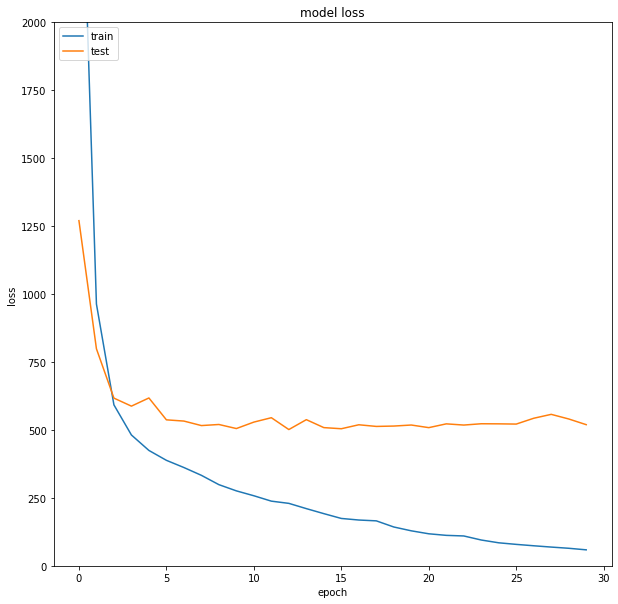

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   112.279999     98.0  14.279999     0.145714   14.571426  20.635626
1    60.153927     69.0   8.846073     0.128204   12.820395  20.635626
2    95.203751     82.0  13.203751     0.161021   16.102135  20.635626
3   111.003006     91.0  20.003006     0.219813   21.981325  20.635626
4   105.376663     93.0  12.376663     0.133082   13.308241  20.635626
5   113.250244     91.0  22.250244     0.244508   24.450817  20.635626
6   117.219322     95.0  22.219322     0.233888   23.388760  20.635626
7    76.275520    111.0  34.724480     0.312833   31.283316  20.635626
8    95.209267     96.0   0.790733     0.008237    0.823681  20.635626
9    92.089622     97.0   4.910378     0.050622    5.062245  20.635626
10   74.797066    124.0  49.202934     0.396798   39.679787  20.635626
11   72.290565     95.0  22.709435     0.239047   23.904667  20.635626
12  121.820892    107.0  14.820892     0.138513   13.851301  20.635626
13   9

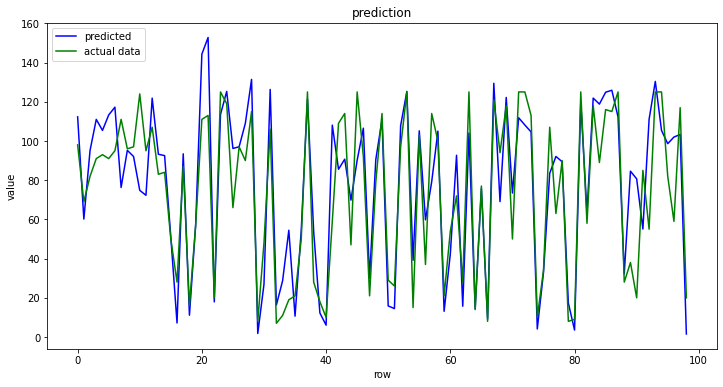

FD001 test RMSE:  20.635625518198953
FD001 test Score:  1484.8732239814758
                            Methods       RMSE        Score  Epochs
0      VGG16 no weights no freezing  16.926955   594.719932     138
1                VGG16 top 2 layers  22.853923  1787.762475     389
2  VGG16 freezing last 15/18 layers  19.317998   824.384289      16
3  VGG16 freezing last 13/18 layers  18.920081   759.492792      18
4   VGG16 freezing last 8/18 layers  20.635626  1484.873224      13
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
______________________________________

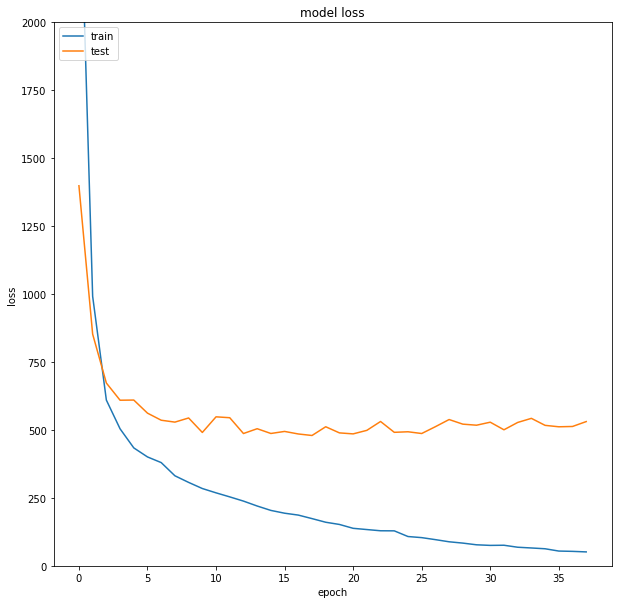

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   131.344040     98.0  33.344040     0.340245   34.024532  18.956616
1    58.436489     69.0  10.563511     0.153094   15.309437  18.956616
2    83.379524     82.0   1.379524     0.016823    1.682347  18.956616
3   102.981384     91.0  11.981384     0.131664   13.166356  18.956616
4    98.301407     93.0   5.301407     0.057004    5.700438  18.956616
5    97.765778     91.0   6.765778     0.074349    7.434920  18.956616
6   121.850487     95.0  26.850487     0.282637   28.263670  18.956616
7    83.236870    111.0  27.763130     0.250118   25.011829  18.956616
8    96.222214     96.0   0.222214     0.002315    0.231473  18.956616
9   103.312218     97.0   6.312218     0.065074    6.507441  18.956616
10   94.506798    124.0  29.493202     0.237848   23.784840  18.956616
11   73.382683     95.0  21.617317     0.227551   22.755070  18.956616
12  127.233711    107.0  20.233711     0.189100   18.910009  18.956616
13  10

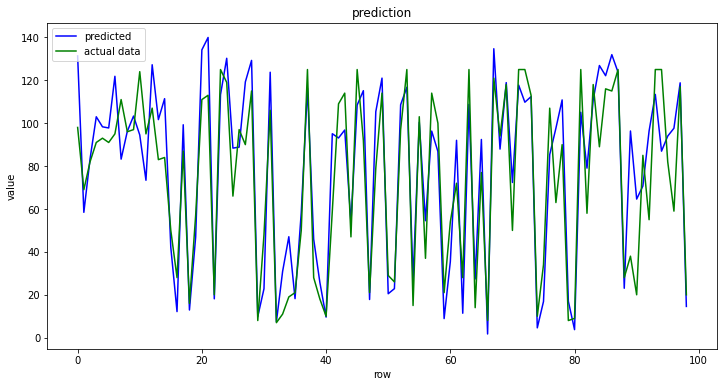

FD001 test RMSE:  18.95661550710925
FD001 test Score:  989.0254714148413
                            Methods       RMSE        Score  Epochs
0      VGG16 no weights no freezing  16.926955   594.719932     138
1                VGG16 top 2 layers  22.853923  1787.762475     389
2  VGG16 freezing last 15/18 layers  19.317998   824.384289      16
3  VGG16 freezing last 13/18 layers  18.920081   759.492792      18
4   VGG16 freezing last 8/18 layers  20.635626  1484.873224      13
5       VGG16 weights + no freezing  18.956616   989.025471      18


In [ ]:
# Inizializzo variabili locali
i = 4
results = []

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')
print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)
for setting in settings:
  mlps_net = network_fit(train_samples, 
                        label_array_train, 
                        test_samples, 
                        label_array_test,
                        model_path = model_path, 
                        model_name = "vgg",
                        weights = setting['weights'],
                        freeze = setting['freeze'],
                        not_train = setting['not_train'],
                        top = setting['top'],
                        verbose=verbose)

  # Train
  trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
  # Test
  rms, score = mlps_net.test_net(trained_net)
  print(subdataset + " test RMSE: ", rms)
  print(subdataset + " test Score: ", score)

  # Carico i risultati o li creo da zero
  try:
    df_results = pd.read_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index_col=False)
    results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
    df_results = df_results.append(results, ignore_index=True)
  except:
    df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

  df_results.to_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index=False)
  print(df_results)

train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
__________________________________________

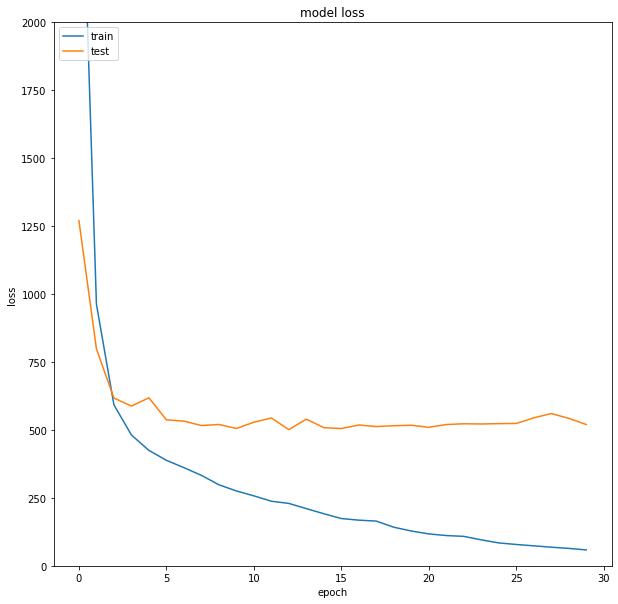

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   112.389877     98.0  14.389877     0.146835   14.683548  20.689659
1    60.287067     69.0   8.712933     0.126274   12.627439  20.689659
2    95.362816     82.0  13.362816     0.162961   16.296118  20.689659
3   111.465172     91.0  20.465172     0.224892   22.489201  20.689659
4   105.968407     93.0  12.968407     0.139445   13.944523  20.689659
5   112.599388     91.0  21.599388     0.237356   23.735592  20.689659
6   117.006592     95.0  22.006592     0.231648   23.164835  20.689659
7    76.366180    111.0  34.633820     0.312016   31.201639  20.689659
8    94.880905     96.0   1.119095     0.011657    1.165724  20.689659
9    92.467934     97.0   4.532066     0.046722    4.672234  20.689659
10   74.548622    124.0  49.451378     0.398801   39.880146  20.689659
11   72.307304     95.0  22.692696     0.238870   23.887049  20.689659
12  121.728859    107.0  14.728859     0.137653   13.765289  20.689659
13   9

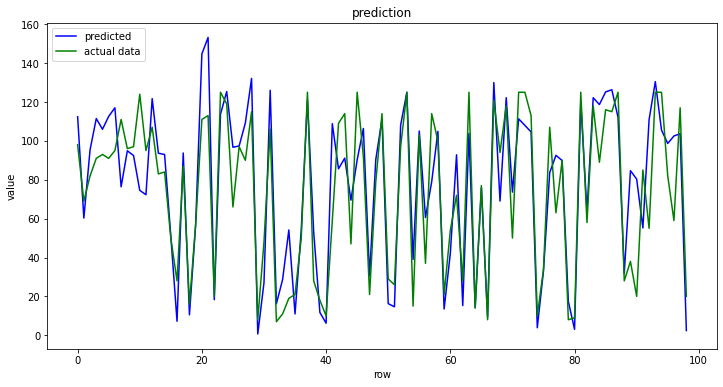

FD001 test RMSE:  20.68965879856823
FD001 test Score:  1487.893634674833
                            Methods       RMSE        Score  Epochs
0      VGG16 no weights no freezing  16.781999   569.393248     138
1                VGG16 top 2 layers  22.853923  1787.763264     389
2  VGG16 freezing last 15/18 layers  19.463747   856.814576      16
3  VGG16 freezing last 13/18 layers  20.689659  1487.893635      13
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64

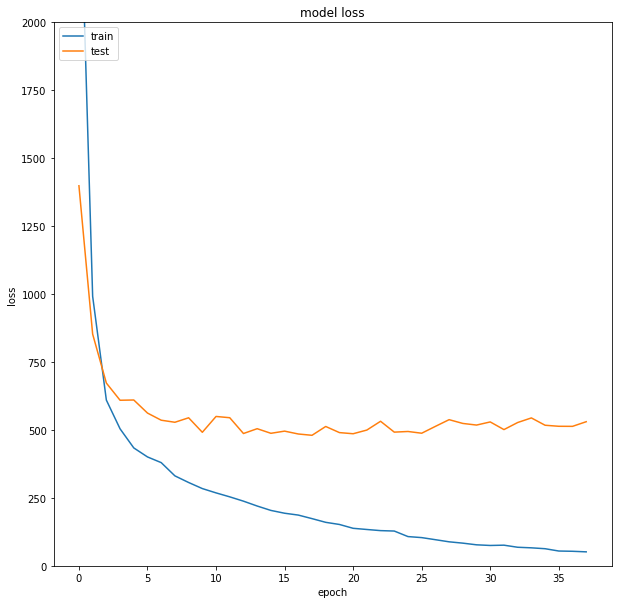

        y_pred  y_truth       diff  diff(ratio)     diff(%)      rmse
0   131.274399     98.0  33.274399     0.339535   33.953468  18.98375
1    58.529766     69.0  10.470234     0.151743   15.174252  18.98375
2    83.087929     82.0   1.087929     0.013267    1.326742  18.98375
3   103.033638     91.0  12.033638     0.132238   13.223778  18.98375
4    98.977768     93.0   5.977768     0.064277    6.427708  18.98375
5    97.788635     91.0   6.788635     0.074600    7.460039  18.98375
6   122.279472     95.0  27.279472     0.287152   28.715235  18.98375
7    82.359596    111.0  28.640404     0.258022   25.802166  18.98375
8    96.215576     96.0   0.215576     0.002246    0.224559  18.98375
9   103.194824     97.0   6.194824     0.063864    6.386416  18.98375
10   94.631073    124.0  29.368927     0.236846   23.684618  18.98375
11   73.862442     95.0  21.137558     0.222501   22.250061  18.98375
12  127.594933    107.0  20.594933     0.192476   19.247601  18.98375
13  101.802185     8

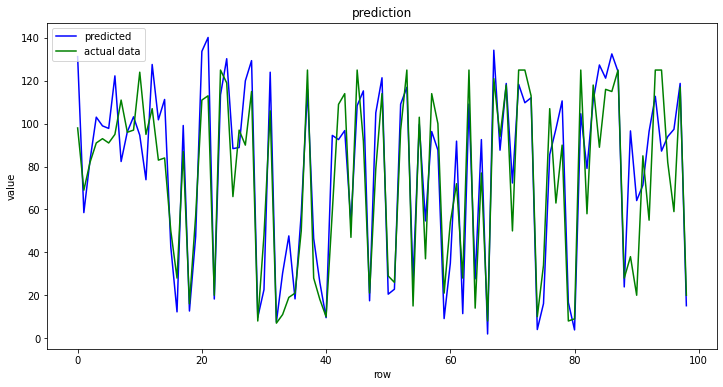

FD001 test RMSE:  18.983750471980553
FD001 test Score:  996.6145851749684
                            Methods       RMSE        Score  Epochs
0      VGG16 no weights no freezing  16.781999   569.393248     138
1                VGG16 top 2 layers  22.853923  1787.763264     389
2  VGG16 freezing last 15/18 layers  19.463747   856.814576      16
3  VGG16 freezing last 13/18 layers  20.689659  1487.893635      13
4   VGG16 freezing last 8/18 layers  18.983750   996.614585      18
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_______________________________________

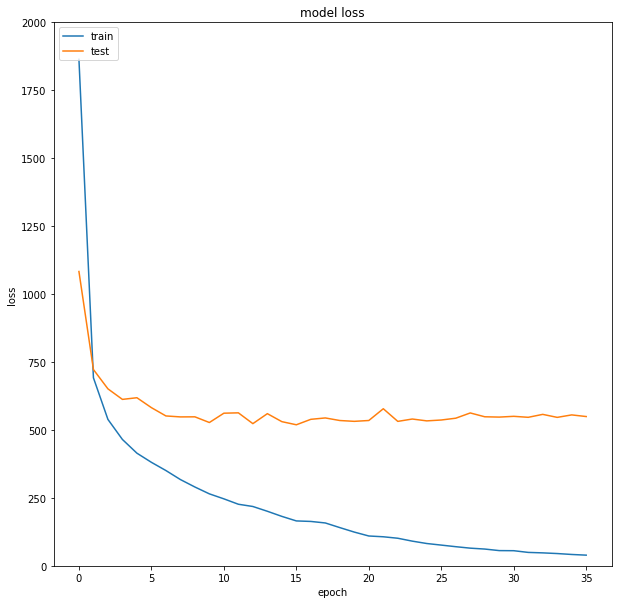

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   124.308640     98.0  26.308640     0.268456   26.845551  19.416069
1    62.386765     69.0   6.613235     0.095844    9.584399  19.416069
2    80.138519     82.0   1.861481     0.022701    2.270098  19.416069
3   113.978416     91.0  22.978416     0.252510   25.251007  19.416069
4   103.554153     93.0  10.554153     0.113486   11.348553  19.416069
5   105.704102     91.0  14.704102     0.161584   16.158352  19.416069
6   101.312149     95.0   6.312149     0.066444    6.644367  19.416069
7    96.906677    111.0  14.093323     0.126967   12.696688  19.416069
8   100.723122     96.0   4.723122     0.049199    4.919918  19.416069
9    99.378700     97.0   2.378700     0.024523    2.452268  19.416069
10   82.522034    124.0  41.477966     0.334500   33.449970  19.416069
11   90.920654     95.0   4.079346     0.042940    4.294048  19.416069
12  100.878197    107.0   6.121803     0.057213    5.721312  19.416069
13  10

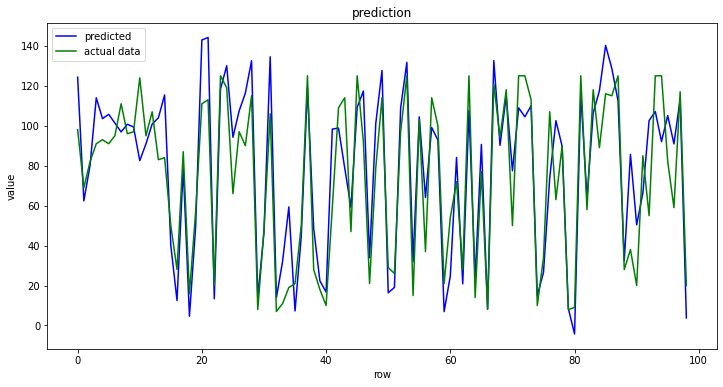

FD001 test RMSE:  19.416068966988643
FD001 test Score:  840.2439190818075
                            Methods       RMSE        Score  Epochs
0      VGG16 no weights no freezing  16.781999   569.393248     138
1                VGG16 top 2 layers  22.853923  1787.763264     389
2  VGG16 freezing last 15/18 layers  19.463747   856.814576      16
3  VGG16 freezing last 13/18 layers  20.689659  1487.893635      13
4   VGG16 freezing last 8/18 layers  18.983750   996.614585      18
5       VGG16 weights + no freezing  19.416069   840.243919      16


In [ ]:
# Inizializzo variabili locali
i = 5
results = []

# Inizio la fase di training
if (train_num in [20, 40]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples'+str(i)+'.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train'+str(i)+'.npy')
if (train_num in [60,80]):
  train_samples = np.load(current_dir +'/preprocess_'+str(train_num)+'/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess_'+str(train_num)+'/label_array_train.npy')
else:
  train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
  label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')
print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)
# Run experiments (6 esperimenti)
for setting in settings:
  mlps_net = network_fit(train_samples, 
                        label_array_train, 
                        test_samples, 
                        label_array_test,
                        model_path = model_path, 
                        model_name = "vgg",
                        weights = setting['weights'],
                        freeze = setting['freeze'],
                        not_train = setting['not_train'],
                        top = setting['top'],
                        verbose=verbose)

  # Train
  trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
  # Test
  rms, score = mlps_net.test_net(trained_net)
  print(subdataset + " test RMSE: ", rms)
  print(subdataset + " test Score: ", score)

  # Carico i risultati o li creo da zero
  try:
    df_results = pd.read_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index_col=False)
    results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])
    df_results = df_results.append(results, ignore_index=True)
  except:
    df_results = pd.DataFrame([[setting['title'], rms, score,stop_epoch]], columns=["Methods", "RMSE", "Score", "Epochs"])

  df_results.to_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv', index=False)
  print(df_results)

# Performance Evaluation

In evaluating these performance it must be taken into account that there was no random sampling and that only the first 20, 40, 60, and 80 elements in order were taken into consideration. This means that there is no randomness in the data.

train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 6

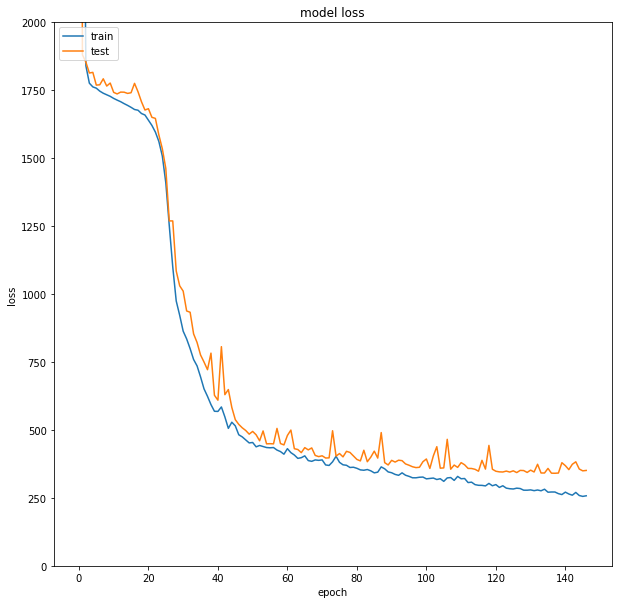

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   119.579765     98.0  21.579765     0.220202   22.020168  16.850586
1    55.503769     69.0  13.496231     0.195598   19.559755  16.850586
2   106.038239     82.0  24.038239     0.293149   29.314926  16.850586
3    96.241325     91.0   5.241325     0.057597    5.759698  16.850586
4   106.252792     93.0  13.252792     0.142503   14.250315  16.850586
5    96.975533     91.0   5.975533     0.065665    6.566519  16.850586
6   111.895874     95.0  16.895874     0.177851   17.785130  16.850586
7   107.685387    111.0   3.314613     0.029861    2.986138  16.850586
8   106.851364     96.0  10.851364     0.113035   11.303505  16.850586
9    90.109505     97.0   6.890495     0.071036    7.103603  16.850586
10   94.190933    124.0  29.809067     0.240396   24.039570  16.850586
11   71.275604     95.0  23.724396     0.249730   24.973049  16.850586
12  127.779007    107.0  20.779007     0.194196   19.419632  16.850586
13   8

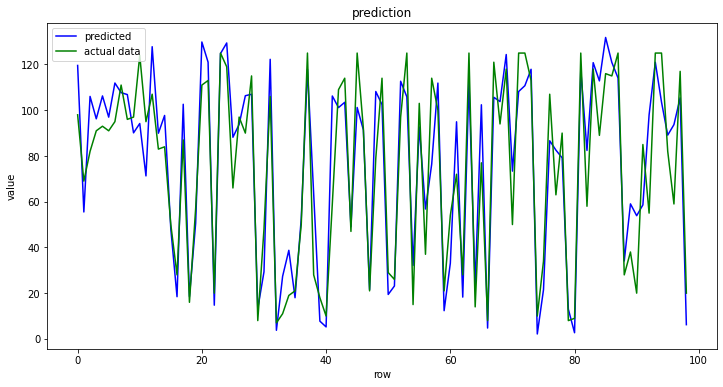

FD001 test RMSE:  16.850586361969352
FD001 test Score:  565.258180885661
[['VGG16 no weights no freezing', 16.850586361969352, 565.258180885661, 138]]
58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________

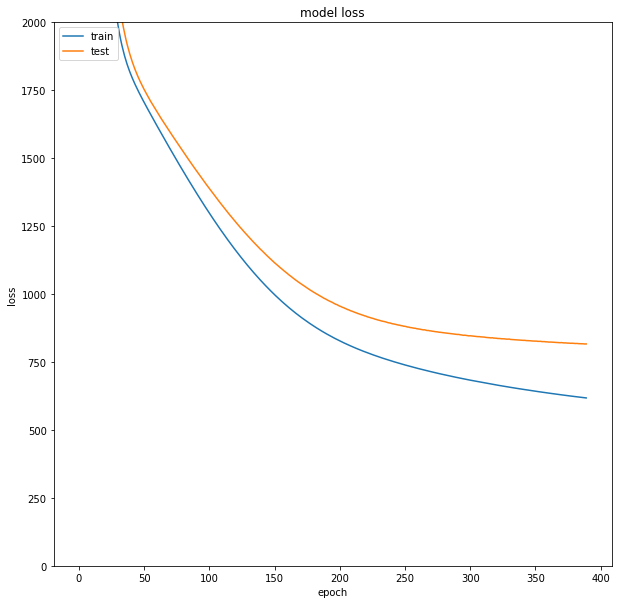

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   103.524696     98.0   5.524696     0.056374    5.637445  22.853923
1    73.450836     69.0   4.450836     0.064505    6.450487  22.853923
2    88.725708     82.0   6.725708     0.082021    8.202083  22.853923
3    86.609566     91.0   4.390434     0.048247    4.824653  22.853923
4    97.511383     93.0   4.511383     0.048509    4.850949  22.853923
5   105.305305     91.0  14.305305     0.157201   15.720116  22.853923
6    89.334190     95.0   5.665810     0.059640    5.964010  22.853923
7    94.216019    111.0  16.783981     0.151207   15.120705  22.853923
8    96.638855     96.0   0.638855     0.006655    0.665474  22.853923
9    68.682167     97.0  28.317833     0.291936   29.193644  22.853923
10   61.309803    124.0  62.690197     0.505566   50.556610  22.853923
11   67.293175     95.0  27.706825     0.291651   29.165081  22.853923
12  106.748550    107.0   0.251450     0.002350    0.235000  22.853923
13  11

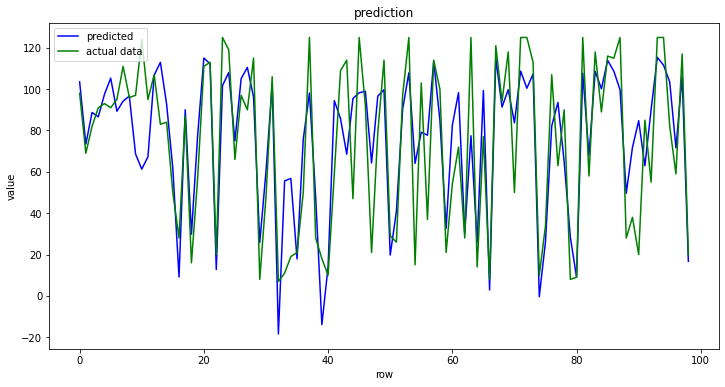

FD001 test RMSE:  22.853923489144183
FD001 test Score:  1787.763263733341
[['VGG16 no weights no freezing', 16.850586361969352, 565.258180885661, 138], ['VGG16 top 2 layers', 22.853923489144183, 1787.763263733341, 389]]
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_____________________________________

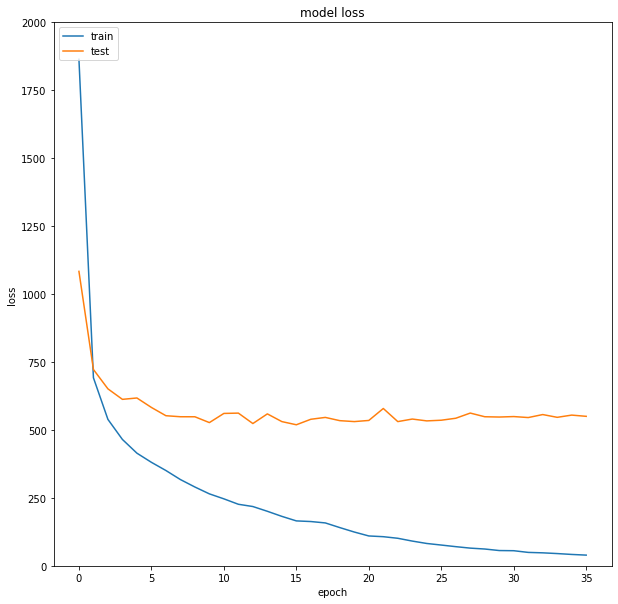

        y_pred  y_truth       diff  diff(ratio)     diff(%)      rmse
0   124.238098     98.0  26.238098     0.267736   26.773569  19.43721
1    62.389374     69.0   6.610626     0.095806    9.580617  19.43721
2    79.051598     82.0   2.948402     0.035956    3.595613  19.43721
3   113.923851     91.0  22.923851     0.251910   25.191044  19.43721
4   103.599792     93.0  10.599792     0.113976   11.397626  19.43721
5   106.062637     91.0  15.062637     0.165523   16.552349  19.43721
6   101.173317     95.0   6.173317     0.064982    6.498228  19.43721
7    97.477249    111.0  13.522751     0.121827   12.182658  19.43721
8   100.548218     96.0   4.548218     0.047377    4.737727  19.43721
9    99.684105     97.0   2.684105     0.027671    2.767118  19.43721
10   82.603600    124.0  41.396400     0.333842   33.384193  19.43721
11   90.903053     95.0   4.096947     0.043126    4.312576  19.43721
12  101.138245    107.0   5.861755     0.054783    5.478276  19.43721
13  103.821678     8

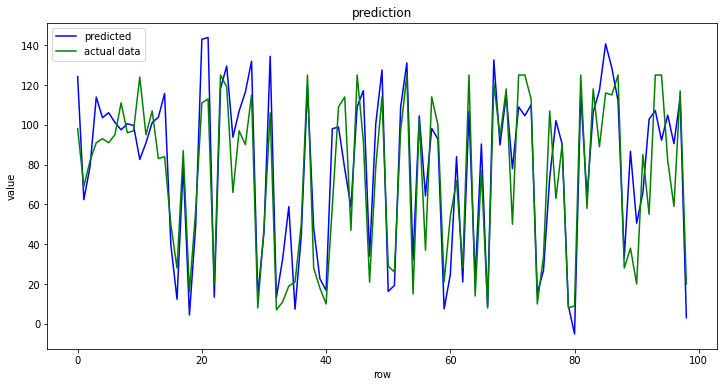

FD001 test RMSE:  19.437209541137683
FD001 test Score:  848.9495476537493
[['VGG16 no weights no freezing', 16.850586361969352, 565.258180885661, 138], ['VGG16 top 2 layers', 22.853923489144183, 1787.763263733341, 389], ['VGG16 freezing last 15/18 layers', 19.437209541137683, 848.9495476537493, 16]]
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D) 

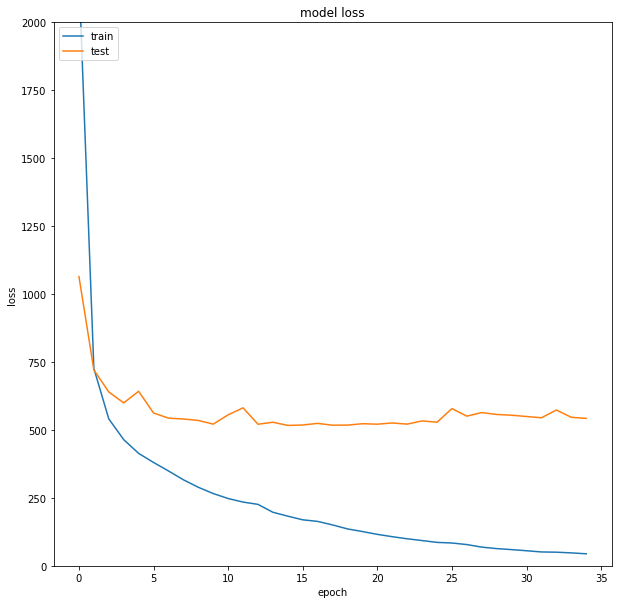

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   120.568306     98.0  22.568306     0.230289   23.028883  18.745783
1    70.139992     69.0   1.139992     0.016522    1.652162  18.745783
2    90.328949     82.0   8.328949     0.101573   10.157255  18.745783
3   109.734055     91.0  18.734055     0.205869   20.586874  18.745783
4    95.719627     93.0   2.719627     0.029243    2.924330  18.745783
5   104.949074     91.0  13.949074     0.153287   15.328653  18.745783
6   105.364525     95.0  10.364525     0.109100   10.910026  18.745783
7    86.810631    111.0  24.189369     0.217922   21.792225  18.745783
8    94.655045     96.0   1.344955     0.014010    1.400995  18.745783
9   102.050705     97.0   5.050705     0.052069    5.206913  18.745783
10   89.765427    124.0  34.234573     0.276085   27.608526  18.745783
11   81.243042     95.0  13.756958     0.144810   14.481009  18.745783
12  105.891716    107.0   1.108284     0.010358    1.035779  18.745783
13  11

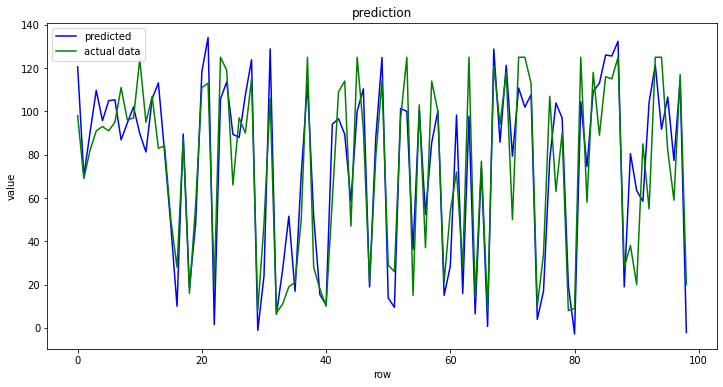

FD001 test RMSE:  18.7457832172394
FD001 test Score:  725.6256702011377
[['VGG16 no weights no freezing', 16.850586361969352, 565.258180885661, 138], ['VGG16 top 2 layers', 22.853923489144183, 1787.763263733341, 389], ['VGG16 freezing last 15/18 layers', 19.437209541137683, 848.9495476537493, 16], ['VGG16 freezing last 13/18 layers', 18.7457832172394, 725.6256702011377, 15]]
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
___________

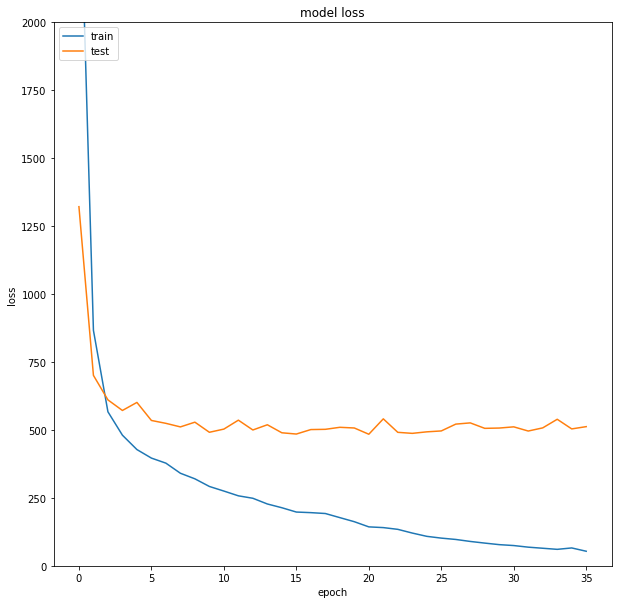

        y_pred  y_truth       diff  diff(ratio)     diff(%)      rmse
0   127.486351     98.0  29.486351     0.300881   30.088116  19.14231
1    52.843731     69.0  16.156269     0.234149   23.414883  19.14231
2    83.172501     82.0   1.172501     0.014299    1.429879  19.14231
3   118.682053     91.0  27.682053     0.304198   30.419838  19.14231
4   107.206032     93.0  14.206032     0.152753   15.275303  19.14231
5   113.792313     91.0  22.792313     0.250465   25.046497  19.14231
6   109.425163     95.0  14.425163     0.151844   15.184383  19.14231
7    94.830421    111.0  16.169579     0.145672   14.567187  19.14231
8    92.189255     96.0   3.810745     0.039695    3.969526  19.14231
9    97.335861     97.0   0.335861     0.003462    0.346249  19.14231
10   85.440681    124.0  38.559319     0.310962   31.096226  19.14231
11   83.398376     95.0  11.601624     0.122122   12.212235  19.14231
12  132.465775    107.0  25.465775     0.237998   23.799789  19.14231
13   94.777428     8

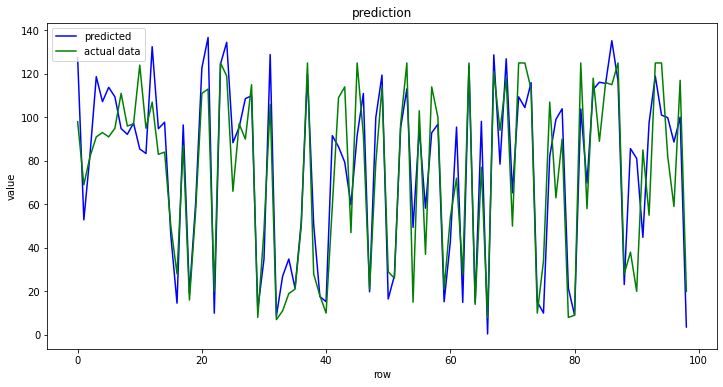

FD001 test RMSE:  19.142310193672582
FD001 test Score:  1081.3323059412141
[['VGG16 no weights no freezing', 16.850586361969352, 565.258180885661, 138], ['VGG16 top 2 layers', 22.853923489144183, 1787.763263733341, 389], ['VGG16 freezing last 15/18 layers', 19.437209541137683, 848.9495476537493, 16], ['VGG16 freezing last 13/18 layers', 18.7457832172394, 725.6256702011377, 15], ['VGG16 freezing last 8/18 layers', 19.142310193672582, 1081.3323059412141, 21]]
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
___________________________________________________________

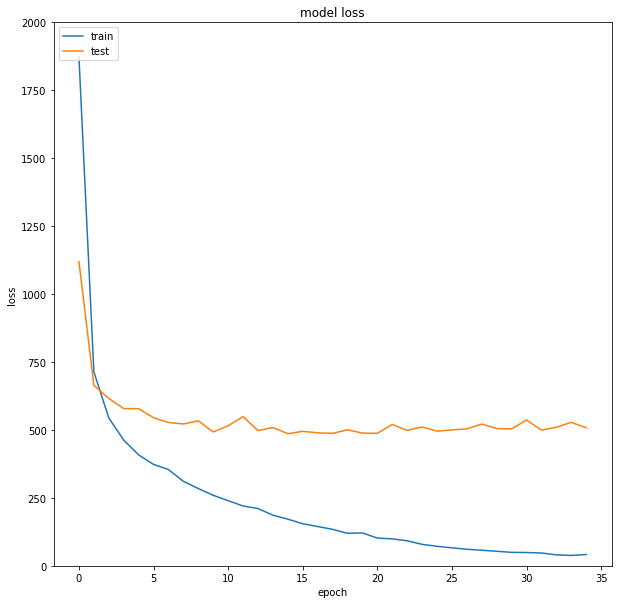

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   109.557602     98.0  11.557602     0.117935   11.793471  19.699849
1    51.298637     69.0  17.701363     0.256541   25.654148  19.699849
2    91.536530     82.0   9.536530     0.116299   11.629913  19.699849
3   104.000237     91.0  13.000237     0.142860   14.285975  19.699849
4    99.911469     93.0   6.911469     0.074317    7.431687  19.699849
5    99.924370     91.0   8.924370     0.098070    9.806999  19.699849
6   104.931145     95.0   9.931145     0.104538   10.453836  19.699849
7    85.350327    111.0  25.649673     0.231078   23.107813  19.699849
8    89.384216     96.0   6.615784     0.068914    6.891441  19.699849
9    96.702301     97.0   0.297699     0.003069    0.306906  19.699849
10   89.143585    124.0  34.856415     0.281100   28.110012  19.699849
11   74.770935     95.0  20.229065     0.212938   21.293753  19.699849
12  118.613937    107.0  11.613937     0.108541   10.854147  19.699849
13   9

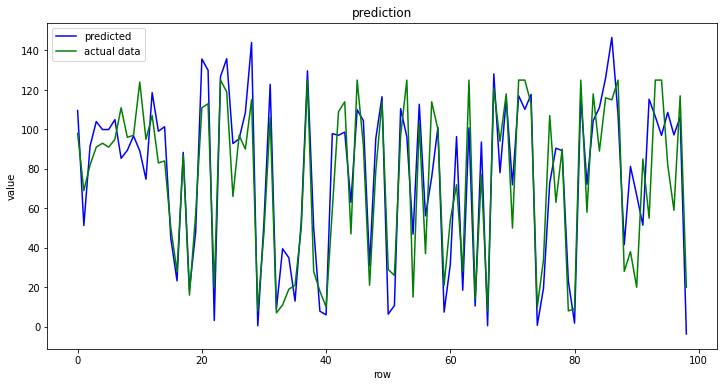

FD001 test RMSE:  19.699848867698357
FD001 test Score:  1085.6832923120692
[['VGG16 no weights no freezing', 16.850586361969352, 565.258180885661, 138], ['VGG16 top 2 layers', 22.853923489144183, 1787.763263733341, 389], ['VGG16 freezing last 15/18 layers', 19.437209541137683, 848.9495476537493, 16], ['VGG16 freezing last 13/18 layers', 18.7457832172394, 725.6256702011377, 15], ['VGG16 freezing last 8/18 layers', 19.142310193672582, 1081.3323059412141, 21], ['VGG16 weights + no freezing', 19.699848867698357, 1085.6832923120692, 15]]


In [ ]:
# Total train examples
results = []
test_samples = np.load(current_dir +'/preprocess/test_samples.npy')
label_array_test = np.load(current_dir +'/preprocess/label_array_test.npy')
train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)

#Run experiments
for setting in settings:
  mlps_net = network_fit(train_samples, 
                        label_array_train, 
                        test_samples, 
                        label_array_test,
                        model_path = model_path, 
                        model_name = "vgg",
                        weights = setting['weights'],
                        freeze = setting['freeze'],
                        not_train = setting['not_train'],
                        top = setting['top'],
                        verbose=verbose)

  #Train
  trained_net, stop_epoch = mlps_net.train_net(epochs=epochs, batch_size=batch)
  # Test
  rms, score = mlps_net.test_net(trained_net)
  print(subdataset + " test RMSE: ", rms)
  print(subdataset + " test Score: ", score)
  results.append([setting['title'], rms, score,stop_epoch])
  print(results)

df_results = pd.DataFrame(results, columns=["Methods", "RMSE", "Score", "Epochs"])
df_results.to_csv(current_dir + '/Train_total_results.csv')

In [ ]:
df_results = pd.DataFrame(results, columns=["Methods", "RMSE", "Score", "Epochs"])
df_results.to_csv(current_dir + '/results/Results'+str(train_num)+'/Train_results'+str(i)+'.csv')

In [ ]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# load dataset
twenty = pd.read_csv(current_dir + '/Train20_results.csv')
twenty.rename(columns={'Unnamed: 0': 'N_training'}, inplace=True)
twenty = twenty.assign(N_training = 20)
forty = pd.read_csv(current_dir + '/Train40_results.csv')
forty.rename(columns={'Unnamed: 0': 'N_training'}, inplace=True)
forty = forty.assign(N_training = 40)
sixty = pd.read_csv(current_dir + '/Train60_results.csv')
sixty.rename(columns={'Unnamed: 0': 'N_training'}, inplace=True)
sixty = sixty.assign(N_training = 60)
eighty = pd.read_csv(current_dir + '/Train80_results.csv')
eighty.rename(columns={'Unnamed: 0': 'N_training'}, inplace=True)
eighty = eighty.assign(N_training = 80)
hundred  = pd.read_csv(current_dir + '/Train_total_results.csv')
hundred.rename(columns={'Unnamed: 0': 'N_training'}, inplace=True)
hundred = hundred.assign(N_training = 100)

performance = pd.concat([twenty, forty, sixty, eighty, hundred])
performance

,N_training,Methods,RMSE,Score,Epochs
0,20,VGG16 no weights no freezing,20.812569,1407.842806,284
1,20,VGG16 top 2 layers,27.175244,8045.293865,1026
2,20,VGG16 freezing last 15/18 layers,22.481971,1488.591775,30
3,20,VGG16 freezing last 13/18 layers,23.335123,2446.913024,40
4,20,VGG16 freezing last 8/18 layers,21.671053,1878.647903,22
5,20,VGG16 weights + no freezing,22.614341,1864.516712,12
0,40,VGG16 no weights no freezing,40.244130,12289.712697,25
1,40,VGG16 top 2 layers,24.742928,6435.744037,692
2,40,VGG16 freezing last 15/18 layers,21.562160,852.621497,23
3,40,VGG16 freezing last 13/18 layers,21.767439,1317.191431,23


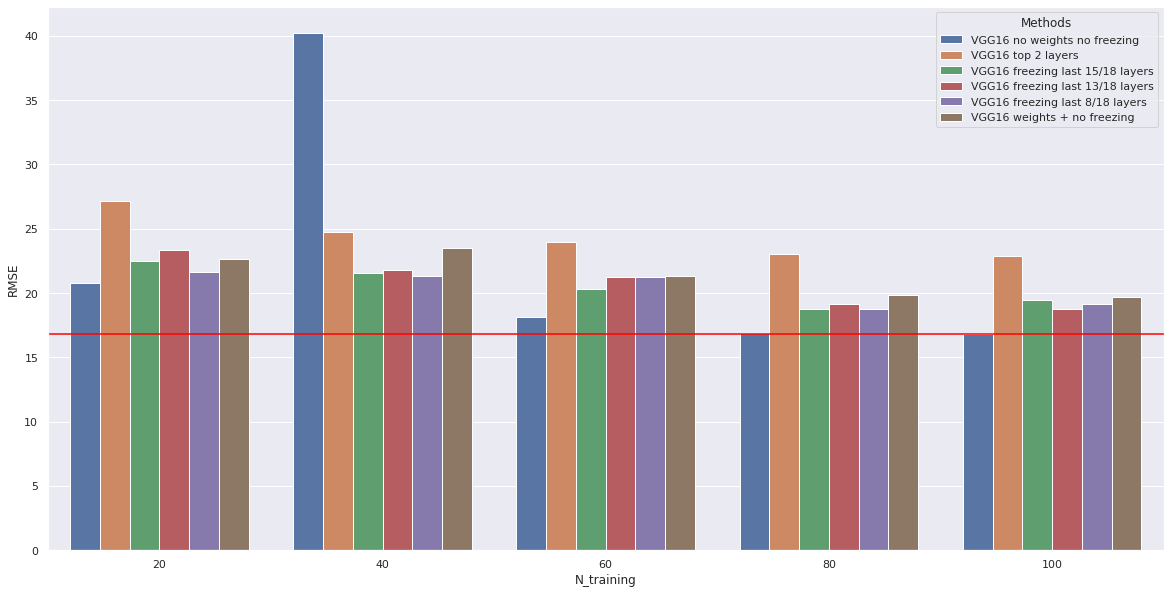

In [ ]:
# RMSE Analysis
plt.figure(figsize=(20, 10))
sns.barplot(x="N_training", y="RMSE", hue="Methods", data=performance, ci=None).axhline(min(performance['RMSE']), color='red');

As you would expect, the RMSE values ​​drop slightly each time the training examples increase. With the exception of the 40 training data but I think it may be given by some outlier.
Generally the best performance on RMSE is obtained using only the structure of the VGG16, without any initialization of the weights.
We can say that, for the RMSE, there is no better performance than 80% to 100% of the training examples.

(0.0, 3000.0)

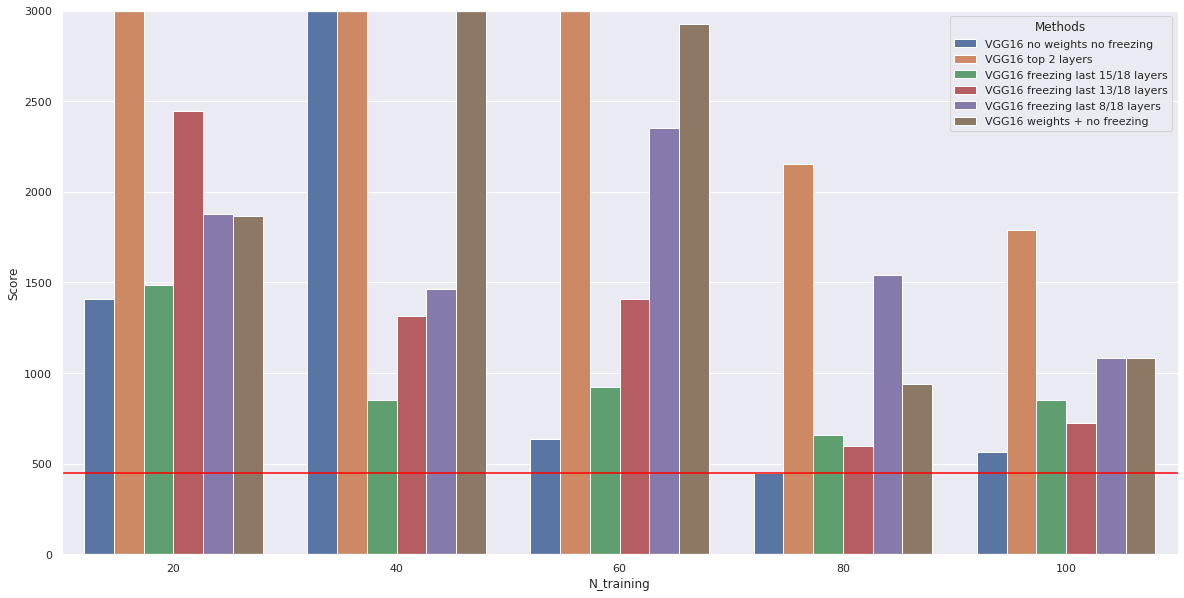

In [ ]:
# Score Analysis
plt.figure(figsize=(20, 10))
sns.barplot(x="N_training", y="Score", hue="Methods", data=performance, ci=None).axhline(min(performance['Score']), color='red');
plt.ylim(0, 3000) # too high performances have been hidden as useless for analytical purposes 

By checking the score values ​​we can say that the best performances are obtained by evaluating 80% of the training set. The score is the unit of measurement that has been chosen to best evaluate this particular dataset. In particular, freezing most of the last layers leads to score levels close to just using the structure.
These results lead to the conclusion that by improving some hyperparameters it is possible to arrive at performances that equal the initialization from scratch.

(0.0, 300.0)

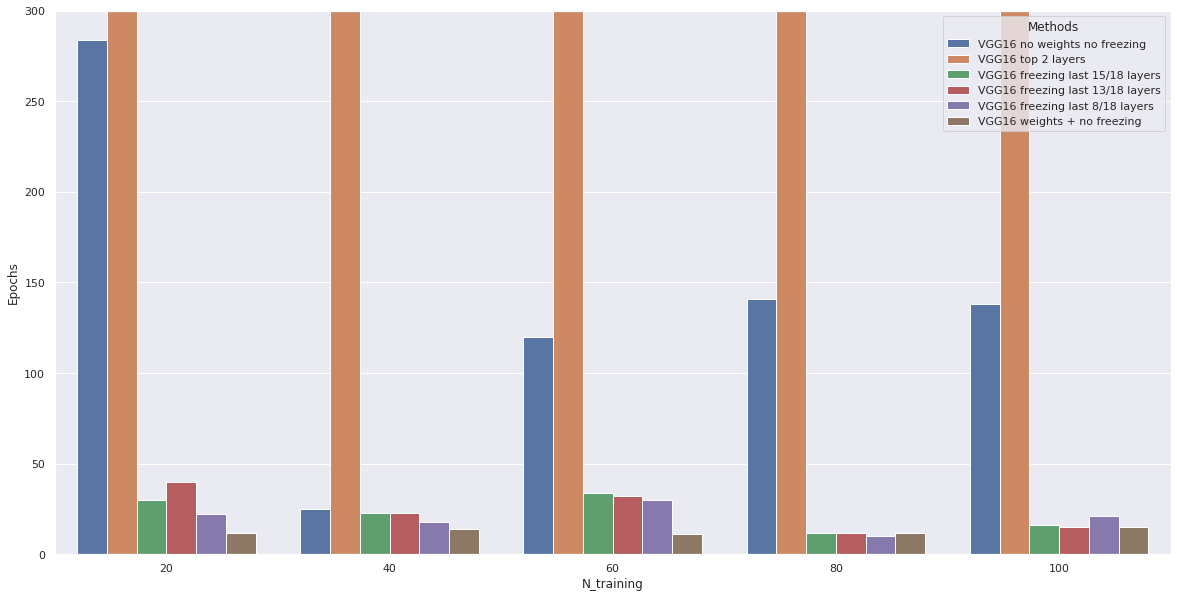

In [ ]:
# Epochs analysis
plt.figure(figsize=(20, 10))
sns.barplot(x="N_training", y="Epochs", hue="Methods", data=performance, ci=None)
plt.ylim(0, 300) # too high performances have been hidden as useless for analytical purposes

As expected from the theory, transfer learning has a very strong impact on temporal performance. From the data reported in this latest report it is clear that using weights always brings benefits to the speed of convergence. Freezing the first layers does not bring any benefit and it does not depend on the number of training data.


# Conclusion

In conclusion, the best performances are obtained using only the structure of the VGG16.
After this there are good performances even when freezing 15/13 levels out of 18.

Questions for Hyunho:
* Do you think I have to initiate more experiments of the same type and make an average of the results obtained? (Example: I randomly sample 10 times the 20% of the data, to evaluate the performance and make an average)
* Do I need to try other neural networks and test those too? Because it seems to me that the evaluations I'm doing depend largely on VGG16
* Are the conclusions I have reached correct or is there some error? In case I would like to discuss it on slack when you have time.


Answers for Francesco:


*   Do you think I have to initiate more experiments of the same type and make an average of the results obtained? (Example: I randomly sample 10 times the 20% of the data, to evaluate the performance and make an average) - "Yes, it deserves to consider the random sampling and averaging. To the best of my knowledge and previous experience, a bias from the sampling from the training set does not much affect to the final performance (I mean, this may not provide you largely different results w.r.t the aboves), but the additional experiments definitely help you write a solid analysis of your experiments. Please note that if you can find a weekness of your experiments, then reviewers also can claim about that. In the FD001 of C-MAPSS dataset, the original training set consists of run-to-failure trajectories of 100 engines and therefore just one line of code that randomly mix the order of those engines before loading the training data would be enough for the implementation. (just use the first or last 20% of data for training after that). And 5 times would be enough to derive an average."


*   Do I need to try other neural networks and test those too? Because it seems to me that the evaluations I'm doing depend largely on VGG16 - "I remember that a Mobilenet did not provide us promising results, and this indicates we cannot guarantee a promising result from the extra experiments. But, if you already have python code of DNNs and their trained weight, you can replicate the above experiments for the other DNNS in a short time. In that case, it would be very nice to try before writing your thesis. Otherwise, let's keep this idea for the future. Next Monday, if Giovanni will not claim about what you have done, i recommend you to start the writing first. Then you can do the experiments for generalization when you have enough time after writing most of your thesis. ( And don't forget evaluate your methods on the other sub-datasets: FD002, FD003 and FD004."



*   Are the conclusions I have reached correct or is there some error? In case I would like to discuss it on slack when you have time. - "For me, your conclusion is correct and its reasoning is solid. I hoped transfer learning or weight initialization helps us use smaller number of training samples for the same level of performance, but it isn't. Therefore, you should focus on the benefit you found w.r.t training error convergence when you describe the contribution of your works. In addition, i propose you to consider what is the best method among the six difference training strategy. Considering we have two objectives, prediction accuracy (RMSE or Score) and computational costs (training epochs), it is a very interesting and important task to find the best trade-off solution based on the above results. "






